Since I can't recreate this [R2RT](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html) blog post results with `tf.contrib.layers.batch_norm`, I decided to make a second notebook which will follow closely with the implementation code in the blog.

Let's see how far I can go!

\* You can find the details about batch normalization in this [paper](https://arxiv.org/pdf/1502.03167v3.pdf) if you don't know what it is.

In [1]:
%matplotlib inline
from __future__ import print_function
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
mnist = input_data.read_data_sets("data", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


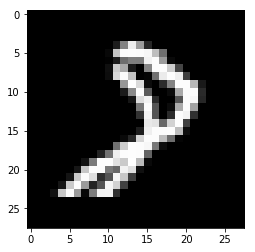

In [3]:
print(mnist.train.labels[3690])
plt.imshow(mnist.train.images[3690].reshape((28, 28)), cmap='gray', interpolation=None)

In [4]:
def batch_norm_wrapper(inputs, is_training=True, decay=0.999, epsilon=1e-5):
    """
    batch_norm_wrapper
    
    Create a batch normalize layers
    
    params
    ======
    - inputs <Tensor>: input Tensor
    - is_training <bool>: running in training mode (True by default)
    - decay <float>: decay rate of the exponentail moving averages
    
    returns
    =======
    - outputs: batch normalized output
    """
    N_features = inputs.get_shape()[-1]
    
    # Trainable variables for batch normalization
    gamma = tf.Variable(tf.ones(N_features), 
                        dtype=tf.float32)
    beta = tf.Variable(tf.zeros(N_features),
                       dtype=tf.float32)
    # non-trainable variables. Make sure it will not be
    # updated with optimizer
    moving_mean = tf.Variable(tf.zeros(N_features),
                              trainable=False,
                              dtype=tf.float32)
    moving_var = tf.Variable(tf.ones(N_features),
                             trainable=False,
                             dtype=tf.float32)
    if is_training:
        train_mean, train_var = tf.nn.moments(inputs, [0])
        update_mean_op = tf.assign(moving_mean, 
                                   decay*moving_mean+(1-decay)*train_mean)
        update_var_op = tf.assign(moving_var,
                                  decay*moving_var+(1-decay)*train_var)
        with tf.control_dependencies([update_mean_op, update_var_op]):
            # use tf.control_dependencies to make sure that update_mean_op and
            # update_var_op will be executed before the evaluation of outputs
            outputs = tf.nn.batch_normalization(inputs, 
                                                train_mean, 
                                                train_var, 
                                                beta, 
                                                gamma, 
                                                epsilon)
    else:
        # Here we will get the moving average mean an variance from restored 
        # session. That is, it will normalized inputs with the moving average
        # learned from training session
        outputs = tf.nn.batch_normalization(inputs,
                                            moving_mean,
                                            moving_var,
                                            beta,
                                            gamma,
                                            epsilon)
    return outputs

In [5]:
w1_init = np.random.normal(size=(784, 100)).astype(np.float32)
w2_init = np.random.normal(size=(100, 100)).astype(np.float32)
w3_init = np.random.normal(size=(100, 10)).astype(np.float32)

In [6]:
def build_graph(graph, is_training=True):
    with graph.as_default():
        x_ = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        
        # layer 1
        W1 = tf.Variable(w1_init, dtype=tf.float32)
        z1 = tf.matmul(x_, W1)
        l1 = tf.nn.sigmoid(batch_norm_wrapper(z1, is_training=is_training))
        
        # layer 2
        W2 = tf.Variable(w2_init, dtype=tf.float32)
        z2 = tf.matmul(l1, W2)
        l2 = tf.nn.sigmoid(batch_norm_wrapper(z2, is_training=is_training))
        
        # layer 3
        W3 = tf.Variable(w3_init, dtype=tf.float32)
        z3 = tf.matmul(l2, W3)
        y = tf.nn.softmax(z3)
        predict = tf.arg_max(y, 1)
        
        loss = -tf.reduce_sum(y_*tf.log(y))
        train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
        
        saver = tf.train.Saver()
    return x_, y_, predict, loss, train_op, saver

In [7]:
def compute_accuracy(y1, y2):
    return 100*(y1 == y2).mean()

In [8]:
n_iteration = 40000
batch_size=100

In [9]:
import time

In [11]:
train_graph = tf.Graph()
x_, y_, predict, loss, train_op, saver = build_graph(train_graph, is_training=True)
accuracy_bn = []
losses_bn = []
tic = time.time()
with tf.Session(graph=train_graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iteration):
        train_images, train_labels = mnist.train.next_batch(batch_size)
        feed_dict = {x_:train_images,
                     y_:train_labels}
        _, l = sess.run([train_op, loss], feed_dict=feed_dict)
        if (step+1) % 100 == 0:
            feed_dict[x_] = mnist.test.images
            feed_dict[y_] = mnist.test.labels
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = compute_accuracy(pred, np.argmax(mnist.test.labels, 1))
            accuracy_bn.append(acc)
            losses_bn.append(l)
        
        if (step+1) % 1000 == 0:
            print("Iteration {}: {} {:.2f}%".format(step+1, l, acc))
    saver.save(sess, "models/batch_norm")
toc = time.time()
print("duration: {:.2f} seconds".format(toc - tic))

Iteration 1000: 31.021595001220703 90.97%
Iteration 2000: 26.601381301879883 92.45%
Iteration 3000: 34.78744125366211 93.15%
Iteration 4000: 23.26113510131836 94.37%
Iteration 5000: 21.285518646240234 94.88%
Iteration 6000: 16.959957122802734 95.48%
Iteration 7000: 9.885022163391113 95.36%
Iteration 8000: 11.311115264892578 95.84%
Iteration 9000: 3.2735230922698975 95.82%
Iteration 10000: 8.537002563476562 96.29%
Iteration 11000: 4.330536842346191 96.33%
Iteration 12000: 8.000665664672852 96.43%
Iteration 13000: 10.391265869140625 96.19%
Iteration 14000: 14.662104606628418 96.45%
Iteration 15000: 4.003668308258057 96.63%
Iteration 16000: 11.870704650878906 96.65%
Iteration 17000: 8.9056396484375 96.66%
Iteration 18000: 4.956634521484375 96.53%
Iteration 19000: 5.6027631759643555 96.61%
Iteration 20000: 1.3056726455688477 96.69%
Iteration 21000: 2.5306553840637207 96.81%
Iteration 22000: 2.732079267501831 96.65%
Iteration 23000: 2.4651522636413574 96.95%
Iteration 24000: 6.8744902610778

In [12]:
predict_graph = tf.Graph()
x_, y_, predict, _, _, saver = build_graph(predict_graph, is_training=False)

with tf.Session(graph=predict_graph) as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "models/batch_norm")
    
    feed_dict = {x_: mnist.test.images,
                 y_: mnist.test.labels}
    pred = sess.run(predict, feed_dict=feed_dict)
    acc = compute_accuracy(pred, np.argmax(mnist.test.labels, 1))
    print("Accuracy in reference phase: {:.2f}%".format(acc))

INFO:tensorflow:Restoring parameters from models/batch_norm
Accuracy in reference phase: 96.65%


Wow....It works. I'll dig into the source codes for both `tf.nn.batch_normalize` and `tf.contrib.layers.batch_norm` to see what goes wrong there (maybe?)

Ok, Let's recreate the results in the blog post!

In [13]:
# network without batch normalization
graph_no_bn = tf.Graph()

with graph_no_bn.as_default():
    x_no_bn = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 784])
    y_no_bn = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 10])
    
    # fully connected layer 1
    W1_no_bn = tf.Variable(w1_init,
                           dtype=tf.float32)
    b1_no_bn = tf.Variable(np.random.randn(w1_init.shape[-1]),
                           dtype=tf.float32)
    z1_no_bn = tf.matmul(x_no_bn, W1_no_bn)+b1_no_bn
    l1_no_bn = tf.nn.sigmoid(z1_no_bn)
    
    # fully connected layer 2
    W2_no_bn = tf.Variable(w2_init, 
                           dtype=tf.float32)
    b2_no_bn = tf.Variable(np.random.randn(w2_init.shape[-1]),
                           dtype=tf.float32)
    z2_no_bn = tf.matmul(l1_no_bn, W2_no_bn)+b2_no_bn
    l2_no_bn = tf.nn.sigmoid(z2_no_bn)
    
    # fully connect layer 3
    W3_no_bn = tf.Variable(w3_init,
                           dtype=tf.float32)
    b3_no_bn = tf.Variable(np.random.randn(w3_init.shape[-1]),
                           dtype=tf.float32)
    l3_no_bn = tf.matmul(l2_no_bn, W3_no_bn)+b3_no_bn
    
    y_hat_no_bn = tf.nn.softmax(l3_no_bn)
    predict_no_bn = tf.argmax(l3_no_bn, 1)
    
    loss_no_bn = -tf.reduce_sum(y_no_bn*tf.log(y_hat_no_bn))
    train_no_nb = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss_no_bn)

In [15]:
losses_no_bn = []
accuracy_no_bn = []

tic = time.time()
with tf.Session(graph=graph_no_bn) as sess:
    tf.global_variables_initializer().run()
    
    for i in range(n_iteration):
        # training
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        feed_dict = {x_no_bn: batch_images, 
                     y_no_bn: batch_labels}
        _, l = sess.run([train_no_nb, loss_no_bn], feed_dict=feed_dict)
        if (i+1) % 100 == 0:
            # prediction
            feed_dict[x_no_bn] = mnist.test.images
            feed_dict[y_no_bn] = mnist.test.labels
            pred = sess.run(predict_no_bn, feed_dict=feed_dict)
            acc = compute_accuracy(pred, np.argmax(mnist.test.labels, axis=1))
            losses_no_bn.append(l)
            accuracy_no_bn.append(acc)
        if (i+1) % 1000 == 0:
            print("Iteration {}: {}, {:.2f}%".format(i+1, l, acc))
toc = time.time()
print("duration: {:.2f} seconds".format(toc - tic))

Iteration 1000: 30.088768005371094, 89.81%
Iteration 2000: 21.84836196899414, 92.21%
Iteration 3000: 19.348957061767578, 93.33%
Iteration 4000: 10.227599143981934, 93.47%
Iteration 5000: 5.144662380218506, 94.15%
Iteration 6000: 18.70578384399414, 94.13%
Iteration 7000: 9.996564865112305, 94.31%
Iteration 8000: 7.02363395690918, 94.63%
Iteration 9000: 2.7547104358673096, 94.63%
Iteration 10000: 3.908397674560547, 94.85%
Iteration 11000: 3.5461461544036865, 94.86%
Iteration 12000: 4.430716514587402, 95.01%
Iteration 13000: 8.070440292358398, 95.02%
Iteration 14000: 4.045376300811768, 94.86%
Iteration 15000: 3.975167751312256, 94.95%
Iteration 16000: 3.5487418174743652, 94.97%
Iteration 17000: 1.7815570831298828, 94.99%
Iteration 18000: 3.9399678707122803, 95.09%
Iteration 19000: 0.9159344434738159, 95.10%
Iteration 20000: 0.8895297646522522, 95.09%
Iteration 21000: 2.0950186252593994, 95.08%
Iteration 22000: 1.0050219297409058, 95.08%
Iteration 23000: 1.8280003070831299, 95.15%
Iteratio

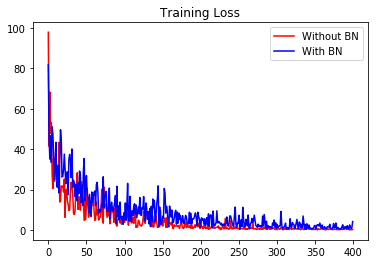

In [16]:
plt.title("Training Loss")
line_no_bn, = plt.plot(losses_no_bn, "-r")
line_bn, = plt.plot(losses_bn, "-b")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])

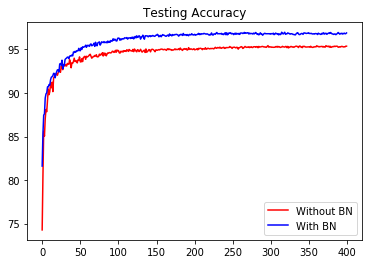

In [17]:
plt.title("Testing Accuracy")
line_no_bn, = plt.plot(accuracy_no_bn, "-r")
line_bn, = plt.plot(accuracy_bn, "-b")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])

Ok, seems like batch normalization is working just like the blog says. 

I'm happy man now. XDD